In [1]:
import pandas as pd
import openpyxl 
import os
import string
from datetime import datetime, timedelta
from pathlib import Path
import urllib
from __future__ import division
import numpy as np
from collections import Counter
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install Spire.Xls
from spire.xls import *
from spire.xls.common import *

In [3]:
wd = os.getcwd()

In [4]:
rawdata_path = os.path.join(wd, "raw_data")
data_path = os.path.join(wd, "data")

In [5]:
# https://www.eia.gov/dnav/pet/pet_sum_mkt_dcu_SCA_m.htm
# PET_SUM_MKT_DCU_SCA_M.xls = California

# https://www.eia.gov/dnav/pet/pet_pri_spt_s1_w.htm
# PET_PRI_SPT_S1_W.xls = spot price

# U.S. On-Highway Diesel Fuel Prices*(dollars per gallon)
# https://www.eia.gov/petroleum/gasdiesel/
# psw18vwall.xls = highway prices

# CPIAUCSL.csv = CPI
# EMM_EPM0_PTE_NUS_DPG.xls = retail prices

In [5]:
def data_from_worksheet(sheetname):

    ws = wb[sheetname]
    
    colnames = [ws.cell(row=2,column=i).value for i in range(1,ws.max_column)]
    colnames[0] = 'Date'
    
    collabels = [ws.cell(row=3,column=i).value for i in range(1,ws.max_column)]
    
    label_dict = {colnames[i]:collabels[i] for i in list(range(0,len(colnames)))}
    
    data_dict = {}
    for key in label_dict.keys():
        data_dict[key] = [ws.cell(row=i,column=list(label_dict.keys()).index(key)+1).value for i in range(4,ws.max_row)]

    df = pd.DataFrame.from_dict(data_dict)
    df = df.set_index('Date')
    
    return df, label_dict

In [6]:
def data_from_workbook():
    
    sheetnames = wb.sheetnames
    sheetnames.remove("Contents")       

    # psw18vwall has weekly and monthly data
    if filename=="psw18vwall":
        sheetnames = ['Data 1', 'Data 3', 'Data 5']
    
    df = pd.DataFrame()
    label_dict = {}
    for sheetname in sheetnames:
        df_, label_dict_ = data_from_worksheet(sheetname)
        df = pd.concat([df,df_], axis='columns')
        label_dict.update(label_dict_)
    
    return df, label_dict

In [7]:
# From Monday to Friday
def last_friday(monday):
    """Input a date and return the date of the first Friday before that date."""
    
    # 4: Friday or 0: Monday
    dias_desde_viernes = (monday.weekday() + 3) % 7
    
    viernes_reciente = monday - timedelta(days=dias_desde_viernes)
    return viernes_reciente.date()

In [8]:
def index_monday_to_friday(df):
    df['Date'] = [last_friday(monday) for monday in df.index]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    return df

In [9]:
def gen_data(df, label_dict):
    """Save df and label_dict into Data folder."""
    
    # Check if index is Friday (4). If not, change it. (0: Monday)
    if df.index[0].weekday() != 4:
        df = index_monday_to_friday(df)
    
    # Check if index is Friday (4)
    assert df.index[0].weekday() == 4
    
    df['Date'] = df.index
    df = df.set_index("Date")
    
    df.to_csv(os.path.join(data_path, area + "_" + data + ".csv"), index=True)
    
    # convert dictionary to JSON string
    label_json = json.dumps(label_dict, indent=4)
    
    # write the JSON string to a file
    with open(os.path.join(data_path, area + "_" + data + ".json"), 'w') as f:
        f.write(label_json)

# 1. Extract

## 1.1. Weekly Supply Estimates

In [ ]:
# https://www.eia.gov/dnav/pet/pet_sum_mkt_dcu_SCA_m.htm
# PET_SUM_MKT_DCU_SCA_M.xls = California


In [10]:
data = "supply"

In [11]:
area_filename_dict = {
    "ca":"PET_SUM_MKT_DCU_SCA_M"
}

In [13]:
%%time
for area, filename in area_filename_dict.items():
    print(area, filename)
    wb = openpyxl.load_workbook(os.path.join(rawdata_path, filename + ".xlsx"))
    df, label_dict = data_from_workbook()
    gen_data(df, label_dict)

ca PET_SUM_MKT_DCU_SCA_M
CPU times: total: 78.1 ms
Wall time: 182 ms


In [ ]:
## 2. Spot Prices for Crude Oil and Petroleum Products

# area = "usa"
# data = "spotprice"
# filename = "PET_PRI_SPT_S1_W"

# %%time
# wb = openpyxl.load_workbook(os.path.join(rawdata_path, filename + ".xlsx"))
# df, label_dict = data_from_workbook()
# gen_data(df, label_dict)

## 3. U.S. On-Highway Diesel Fuel Prices

# area = "usa"
# data = "highwayprice"
# filename = "psw18vwall"

# %%time
# wb = openpyxl.load_workbook(os.path.join(rawdata_path, filename + ".xlsx"))
# df, label_dict = data_from_workbook()
# gen_data(df, label_dict)

In [ ]:
## 1.2. NYMEX Futures Prices

# %%time
# area = "usa"
# data = "nimexprice"
# filename = "PET_PRI_FUT_S1_W"

# wb = openpyxl.load_workbook(os.path.join(rawdata_path, filename + ".xlsx"))
# df, label_dict = data_from_workbook()
# gen_data(df, label_dict)

In [ ]:
## 1.3. Retail Prices for Gasoline, All Grades 

# %%time
# area = "usa"
# data = "retailprice"
# filename = "PET_PRI_GND_A_EPM0_PTE_DPGAL_W"

# wb = openpyxl.load_workbook(os.path.join(rawdata_path, filename + ".xlsx"))
# df, label_dict = data_from_workbook()
# gen_data(df, label_dict)

# 2. Transform

In [97]:
def read_data(filename_csv):
    df = pd.read_csv(os.path.join(data_path, filename_csv))
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index("Date")
    return df

In [98]:
def read_json(filename_json):
    # Opening JSON file
    with open(os.path.join(data_path, filename_json)) as json_file:
        data = json.load(json_file)    
    return data

In [99]:
# CPI: https://fred.stlouisfed.org/series/CPIAUCSL
df_cpi = pd.read_csv(os.path.join(rawdata_path, "CPIAUCSL.csv"))
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'])

In [156]:
df_ca = read_data("ca_supply.csv")

# df_padd1 = read_data("padd1_supply.csv")
# df_padd2 = read_data("padd2_supply.csv")
# df_padd3 = read_data("padd3_supply.csv")
# df_padd4 = read_data("padd4_supply.csv")
# df_padd5 = read_data("padd5_supply.csv")

# df_retailprice = read_data("usa_retailprice.csv")
# df_nimexprice = read_data("usa_nimexprice.csv")

In [157]:
label_dict_ca = read_json("ca_supply.json")

# label_dict_padd1 = read_json("padd1_supply.json")
# label_dict_padd2 = read_json("padd2_supply.json")
# label_dict_padd3 = read_json("padd3_supply.json")
# label_dict_padd4 = read_json("padd4_supply.json")
# label_dict_padd5 = read_json("padd5_supply.json")

# label_dict_retailprice = read_json("usa_retailprice.json")
# label_dict_nimexprice = read_json("usa_nimexprice.json")

In [158]:
# df = pd.concat([df_usa, df_retailprice, df_nimexprice], axis='columns')
# df = pd.concat([df, df_padd1, df_padd2, df_padd3, df_padd4, df_padd5], axis='columns')
# df = df.loc[:,~df.columns.duplicated()].copy()
df = df_ca.copy()

In [159]:
# WGFRPP12 : Y (Weekly East Coast (PADD 1) Refiner and Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day))
# W_EPM0F_SAE_R10_MBBL : K (Weekly East Coast (PADD 1) Ending Stocks of Finished Motor Gasoline  (Thousand Barrels))
# W_EPM0F_IM0_R10-Z00_MBBLD : Weekly East Coast (PADD 1) Imports of Finished Motor Gasoline  (Thousand Barrels per Day)

# df["y_padd1"] = df["WGFRPP12"]
# df["k_padd1"] = df["W_EPM0F_SAE_R10_MBBL"]
# df["i_padd1"] = df["W_EPM0F_IM0_R10-Z00_MBBLD"]

# df['klag_padd1'] = df['k_padd1'].shift(1, axis=0)
# df['dk_padd1'] = df['k_padd1'] - df['klag_padd1']

# df["d_padd1"] = df["y_padd1"] - df['dk_padd1']

In [160]:
# C100050061: d
# MGFSXCA1: k
# EMA_EPM0_PTC_SCA_DPG: pretail

# df["d_ca"] = df["C100050061"] * 30 / 42
df["d_ca"] = df["C100050061"] / 42
df["k_ca"] = df["MGFSXCA1"]

df['klag_ca'] = df['k_ca'].shift(1, axis=0)
df['dk_ca'] = df['k_ca'] - df['klag_ca']

In [161]:
# for i in list(map(str, list(range(1,5+1)))):
#     df["y_padd" + i] = df["WGFRPP" + i + "2"] * 7
#     df["k_padd" + i] = df["W_EPM0F_SAE_R" + i + "0_MBBL"]
#     df["i_padd" + i] = df["W_EPM0F_IM0_R" + i + "0-Z00_MBBLD"] * 7
    
#     df['klag_padd' + i] = df['k_padd' + i].shift(1, axis=0)
#     df['dk_padd' + i] = df['k_padd' + i] - df['klag_padd' + i]
    
#     df["d_padd" + i] = df["y_padd" + i] - df['dk_padd' + i]

#     df["y_padd" + i + "_3mean_rolling"] = df["y_padd" + i].rolling(window=3).mean().shift(1)
    
#     df["dos_padd" + i] = (df["klag_padd" + i] + df["y_padd" + i + "_3mean_rolling"]) / (df["d_padd" + i]/7)

In [162]:
label_dict = {}
label_dict.update(label_dict_ca)
# label_dict.update(label_dict_retailprice)
# label_dict.update(label_dict_nimexprice)

# Total Gasoline: 
# Days of Supply: W_EPM0_VSD_NUS_DAYS
# Retail Price: EMM_EPM0_PTE_NUS_DPG
# Spot Price: EER_EPD2F_PF4_Y35NY_DPG
# Future Price: EER_EPMRR_PE1_Y35NY_DPG
# RBOB Price: EER_EPMRR_PF4_Y05LA_DPG

df['Date'] = df.index

In [163]:
# df = pd.merge(df, df_cpi, how='left', left_on=df['Date'].dt.to_period('M'), right_on=df_cpi['DATE'].dt.to_period('M'))

# # inflation 2024-05
# df['cpi'] = list(df[df['key_0']=='2024-04']['CPIAUCSL'])[0] / df['CPIAUCSL']

# # barrel of oil contains 42 gallons
# df["pr_ca"] = df["EMA_EPM0_PTC_SCA_DPG"] * 42 * df['cpi']

In [164]:
df = df.set_index('Date')

In [165]:
df['Date'] = df.index
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

In [166]:
# Add labels for new data units
# label_dict['dos_usa'] = label_dict['W_EPM0_VSD_NUS_DAYS']
# label_dict['p_retail_usa'] = label_dict['EER_EPMRR_PE1_Y35NY_DPG'].replace("Gallon", "Barrel")
# label_dict['p_nimex'] = label_dict['EER_EPMRR_PE1_Y35NY_DPG'].replace("Gallon", "Barrel")

In [167]:
# C100050061: d
# MGFSXCA1: k
# EMA_EPM0_PTC_SCA_DPG: pretail
label_dict['d_ca'] = label_dict['C100050061'].replace("Gallon", "Barrel")
label_dict['k_ca'] = label_dict['MGFSXCA1']
# label_dict['pr_ca'] = label_dict['EMA_EPM0_PTC_SCA_DPG'].replace("Gallon", "Barrel")

In [168]:
df.to_csv("states.csv", index=True)

# convert dictionary to JSON string
label_json = json.dumps(label_dict, indent=4)

# write the JSON string to a file
with open("states.json", 'w') as f:
    f.write(label_json)

# 3. Plots

In [205]:
# Opening JSON file
with open("states.json") as json_file:
    label_dict = json.load(json_file)   

In [233]:
df = pd.read_csv("states.csv")

## 3.1. Stock

In [206]:
label_dict['k_ca']

'California Finished Motor Gasoline Stocks at Refineries, Bulk Terminals, and Natural Gas Plants (Thousand Barrels)'

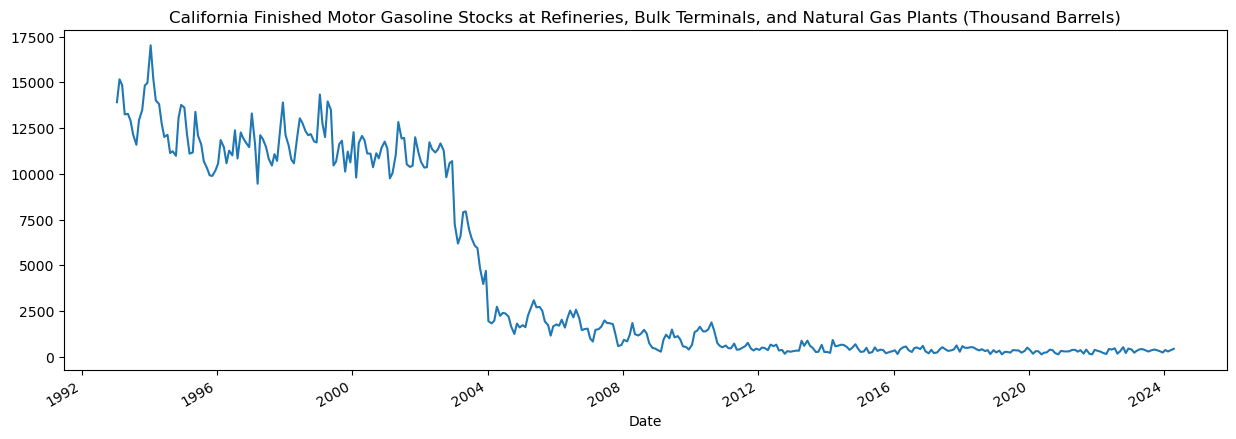

In [230]:
def plot(df, columns):
    df = pd.read_csv("states.csv")
    df = df[['Date', 'k_ca']].dropna()
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(df['Date'])

    df['k_ca'].plot(figsize=(15,5))
    plt.title(label_dict['k_ca'])

columns = ['k_ca']
plot(df, columns)

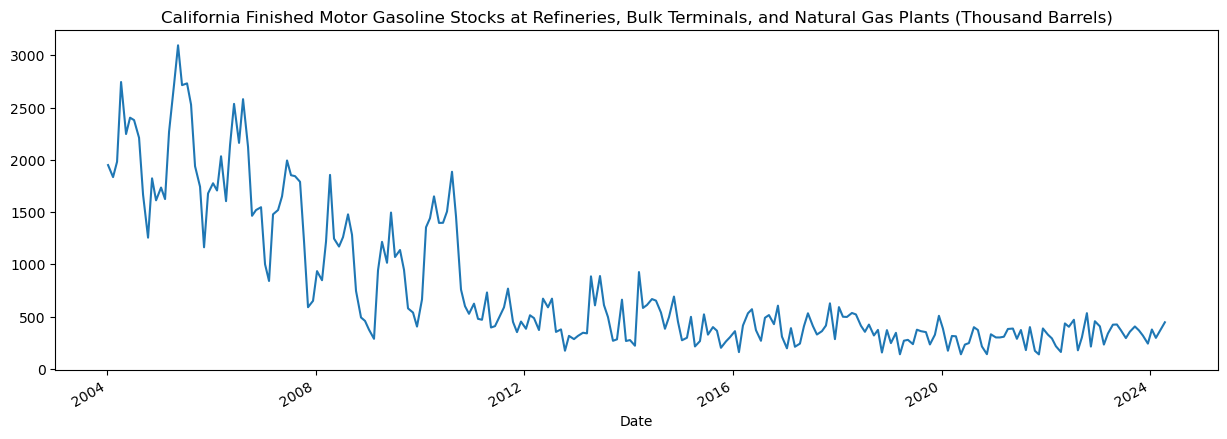

In [229]:
def plot(df, columns):
    df = pd.read_csv("states.csv")
    df = df[['Date', 'k_ca']].dropna()
    
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(df['Date'])
    df['year'] = df['Date'].dt.year
    df = df[df['year']>=2004]

    df['k_ca'].plot(figsize=(15,5))
    plt.title(label_dict['k_ca'])

columns = ['k_ca']
plot(df, columns)

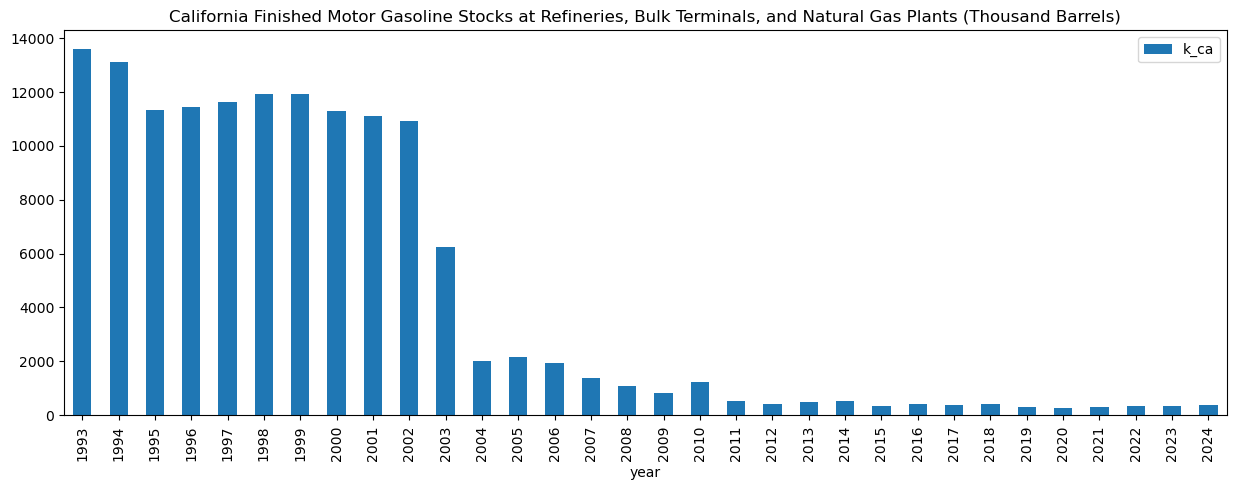

In [228]:
def plot(df, columns):
    df = pd.read_csv("states.csv")
    df = df[['Date', 'k_ca']].dropna()
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    # df = df[df['year']>=2015]
    df = df[['year'] + columns]
    df = df.groupby(['year'])[['k_ca']].mean()
    
    df.plot(kind='bar', figsize=(15,5))
    plt.title(label_dict['k_ca'])

columns = ['k_ca']
plot(df, columns)

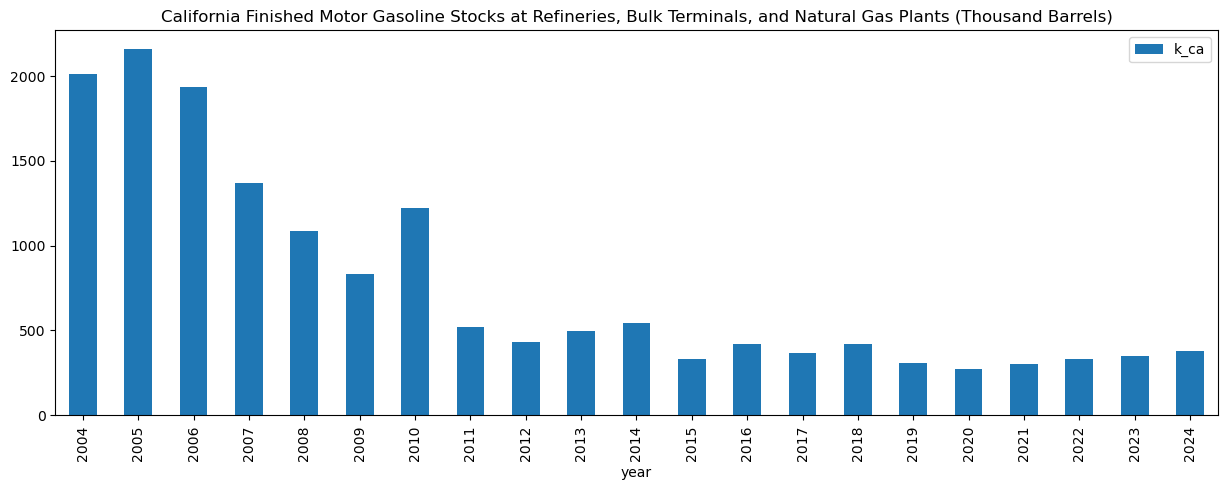

In [231]:
def plot(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df = df[df['year']>=2004]
    df = df[['year'] + columns]
    df = df.groupby(['year'])[['k_ca']].mean()

    df.plot(kind='bar', figsize=(15,5))
    plt.title(label_dict['k_ca'])

columns = ['k_ca']
plot(df, columns)

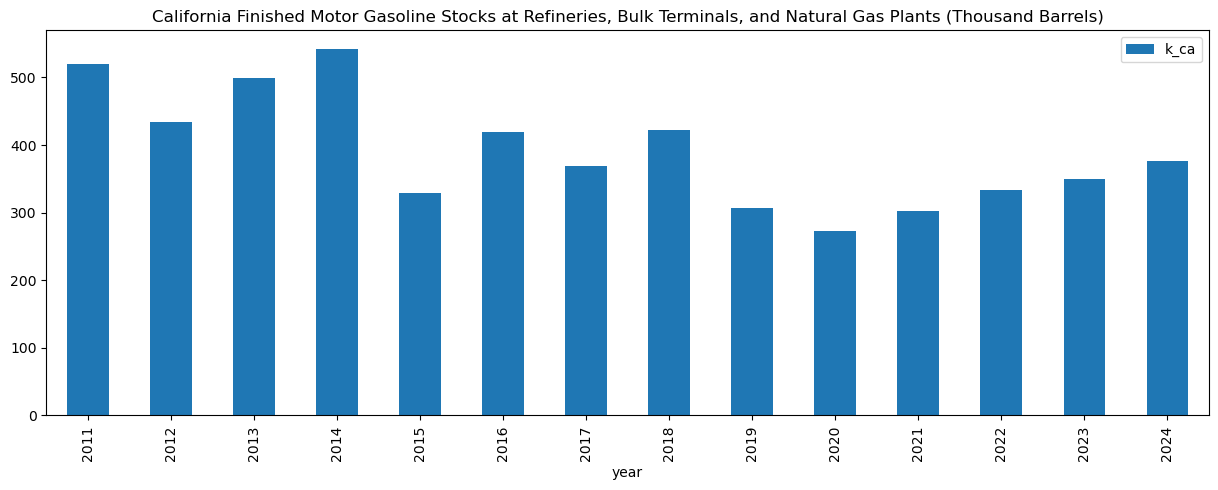

In [232]:
def plot_by_year(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df = df[df['year']>=2011]
    df = df[['year'] + columns]
    df = df.groupby(['year'])[['k_ca']].mean()

    df.plot(kind='bar', figsize=(15,5))
    plt.title(label_dict['k_ca'])

columns = ['k_ca']
plot_by_year(df, columns)

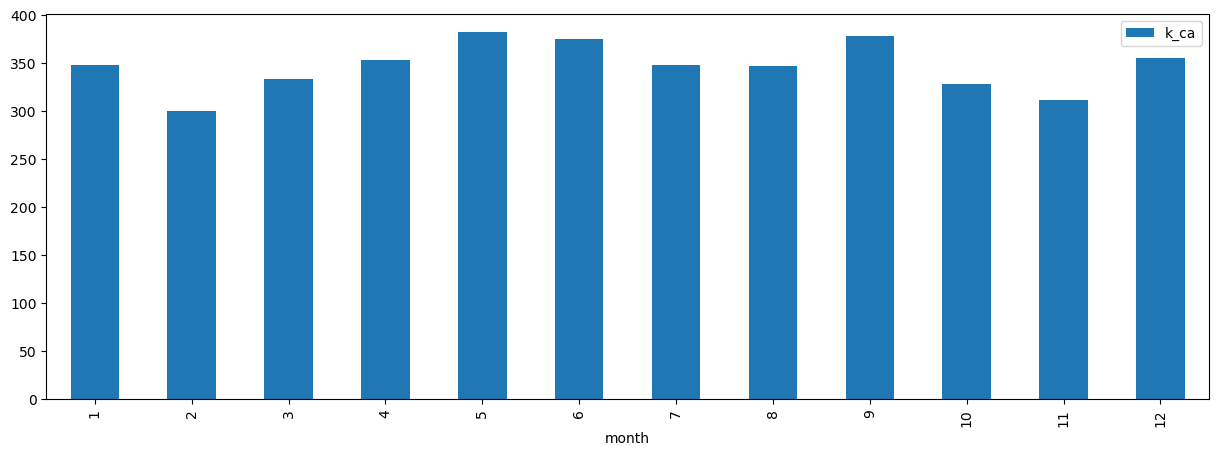

In [182]:
def plot_by_month(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df = df[df['year']>=2015]
    df = df[['month'] + columns]
    df = df.groupby(['month'])[['k_ca']].mean()

    df.plot(kind='bar', figsize=(15,5))

columns = ['k_ca']
plot_by_month(df, columns)

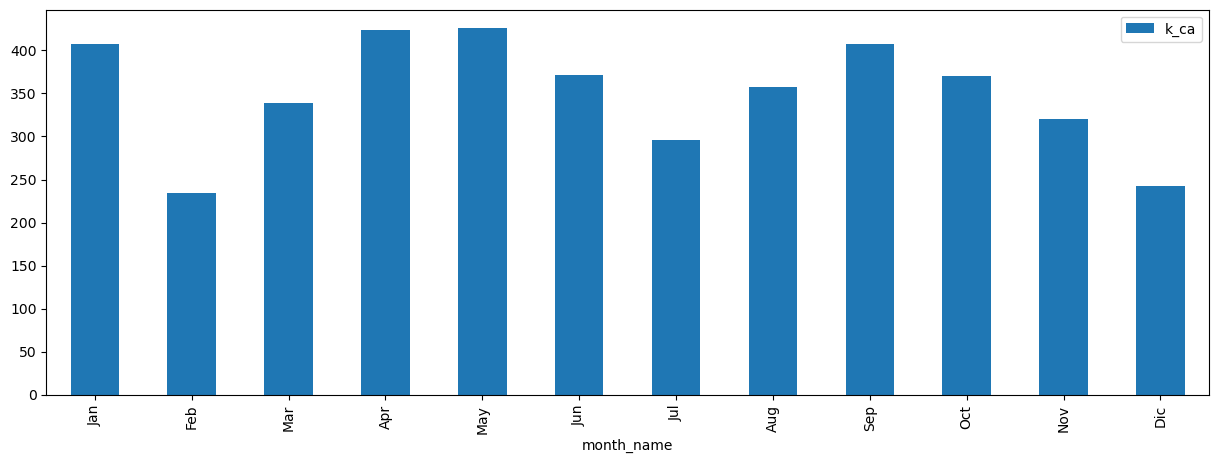

In [191]:
def plot_by_month(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df = df[df['year']==2023]
    df = df[['month'] + columns]
    df = df.groupby(['month'])[['k_ca']].mean()

    month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']
    df['month_name'] = month_list
    df = df.set_index('month_name')
    df = df[['k_ca']]

    df.plot(kind='bar', figsize=(15,5))


columns = ['k_ca']
plot_by_month(df, columns)

## 3.2. Sales

In [176]:
df = pd.read_csv("states.csv")
df = df[['Date', 'd_ca']].dropna()

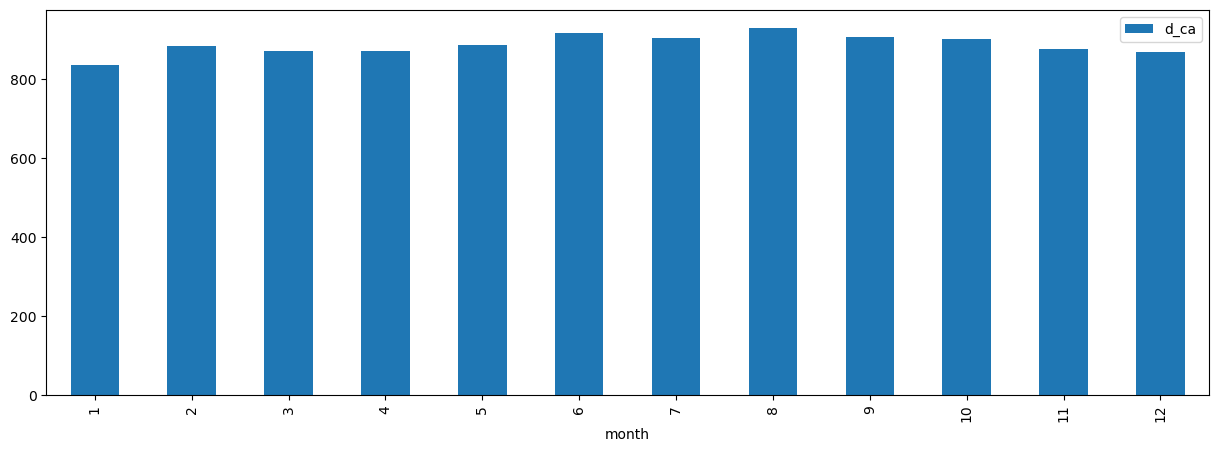

In [178]:
def plot_by_month(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df = df[df['year']>=2015]
    df = df[['month'] + columns]
    df = df.groupby(['month'])[['d_ca']].mean()

    df.plot(kind='bar', figsize=(15,5))


columns = ['d_ca']
plot_by_month(df, columns)

In [151]:
df = pd.read_csv("states.csv")
df = df[['Date', 'd_ca', 'k_ca']].dropna()

In [152]:
df['k/d'] = df['k_ca'] / (df['d_ca']/30)

In [154]:
pd.options.display.float_format = "{:,.2f}".format
df

Date      d_ca      k_ca   k/d
120  1993-01-15 24,981.43 13,914.00 16.71
121  1993-02-12 26,823.93 15,166.00 16.96
122  1993-03-12 27,003.57 14,856.00 16.50
123  1993-04-09 27,458.43 13,254.00 14.48
124  1993-05-14 27,230.29 13,278.00 14.63
..          ...       ...       ...   ...
466  2021-11-12 23,507.43    140.00  0.18
467  2021-12-10 23,229.00    388.00  0.50
468  2022-01-14 21,145.43    329.00  0.47
469  2022-02-11 23,458.29    293.00  0.37
470  2022-03-11 23,281.29    218.00  0.28

[351 rows x 4 columns]

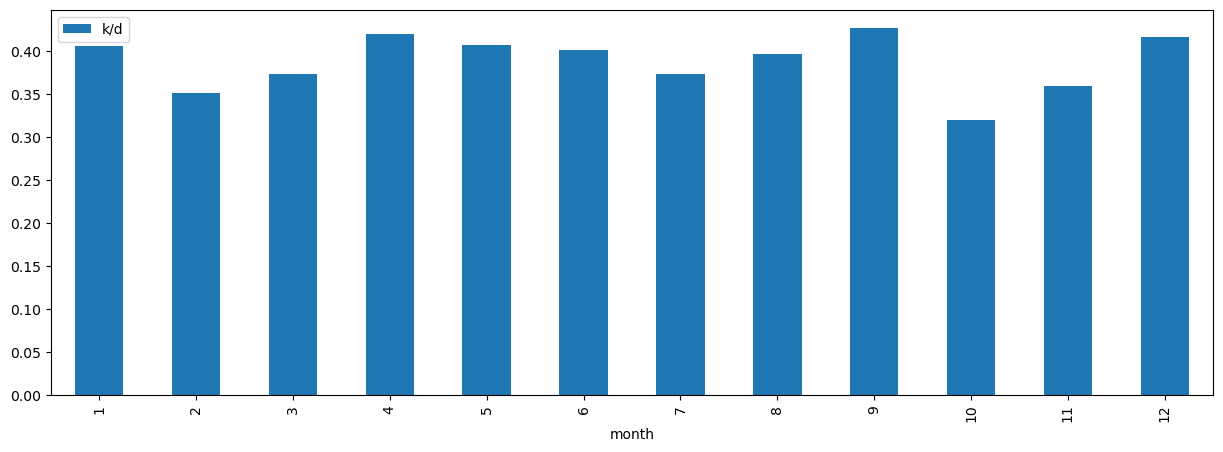

In [155]:
def plot_by_month(df, columns):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df = df[df['year']>=2015]
    df = df[['month'] + columns]
    df = df.groupby(['month'])[['k/d']].mean()

    df.plot(kind='bar', figsize=(15,5))

    
columns = ['k/d']
plot_by_month(df, columns)

''

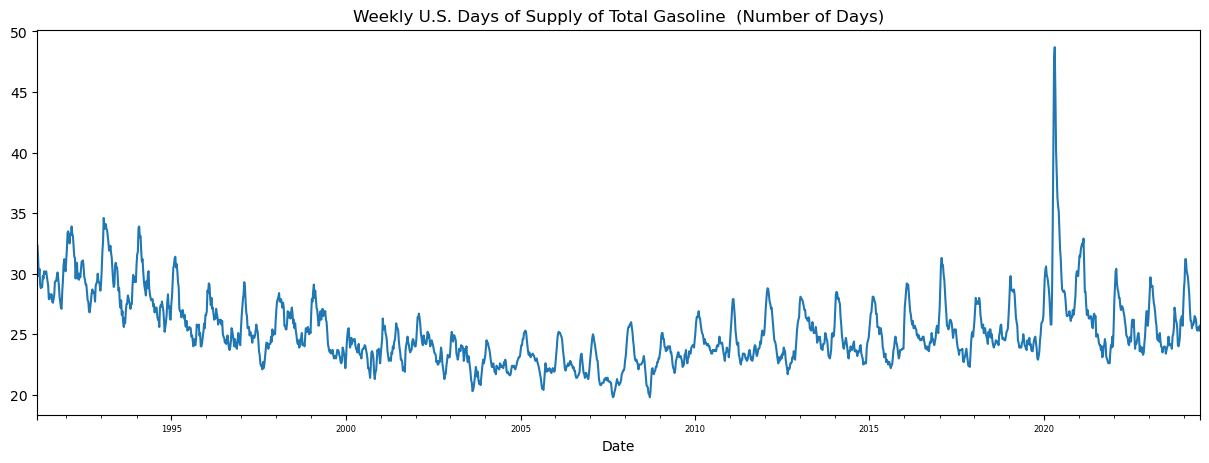

In [31]:
y = df[['dos_usa']].copy()
y = y.dropna()
y['dos_usa'].plot(figsize=(15,5))
plt.xticks(fontsize=6)
# plt.xlabel('X-axis', fontsize=4)
plt.title(label_dict['dos_usa'])
# plt.ylabel("thousands bbls per week")
# plt.xlabel("Destino")
;

In [32]:
from statsmodels.tsa.filters.hp_filter import hpfilter
remaining, trend = hpfilter(y, lamb=270400) # for Annual Data lambda is 270,400

<Axes: xlabel='Date'>

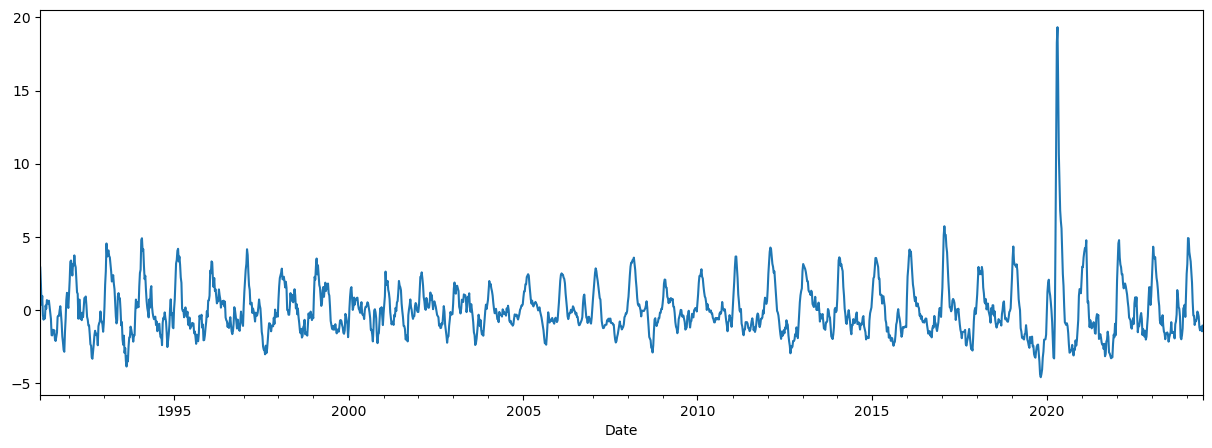

In [33]:
remaining.plot(figsize=(15,5))

<Axes: xlabel='Date'>

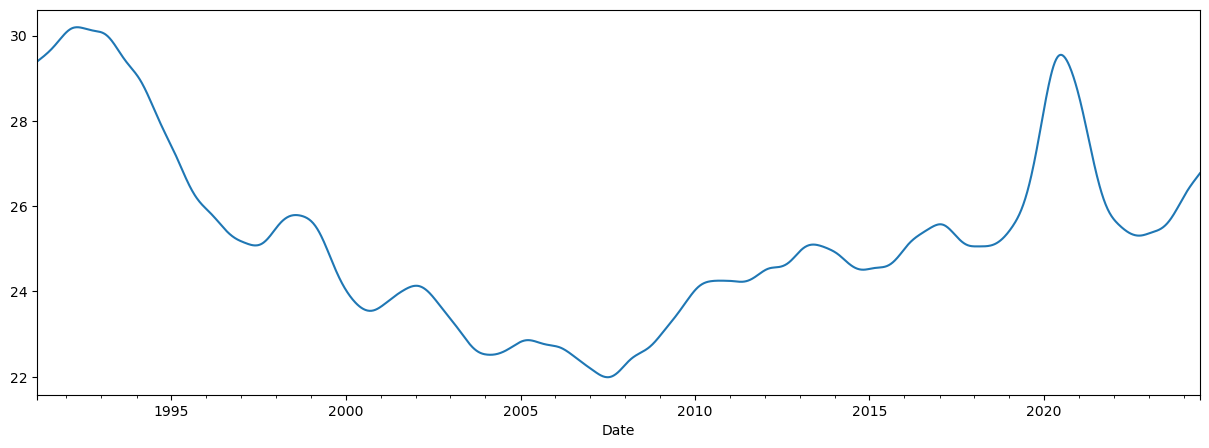

In [34]:
trend.plot(figsize=(15,5))

''

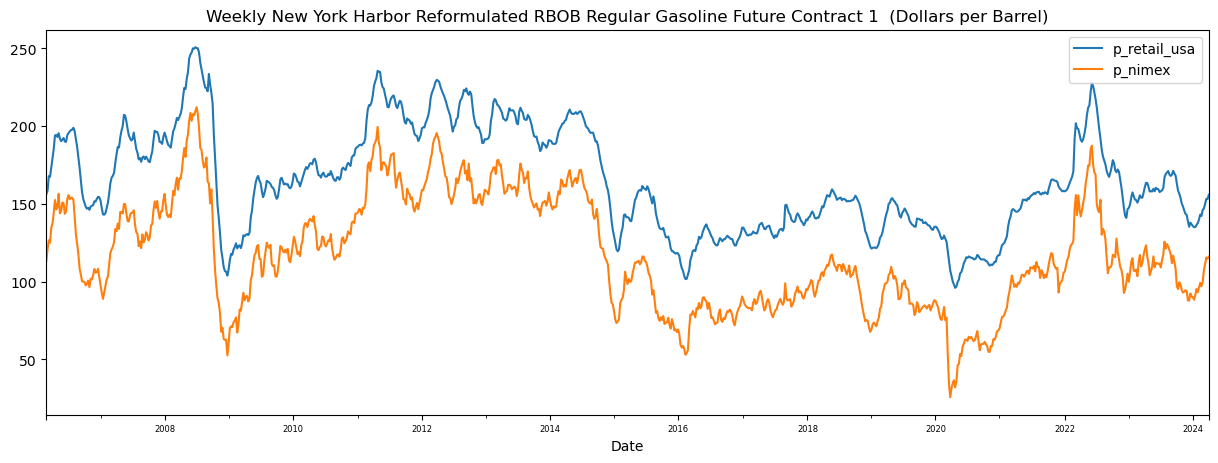

In [35]:
y = df[['p_retail_usa', 'p_nimex']].dropna()
y.plot(figsize=(15,5))
plt.xticks(fontsize=6)
# plt.xlabel('X-axis', fontsize=4)
plt.title(label_dict['p_retail_usa'])
# plt.ylabel("thousands bbls per week")
# plt.xlabel("Destino")
;

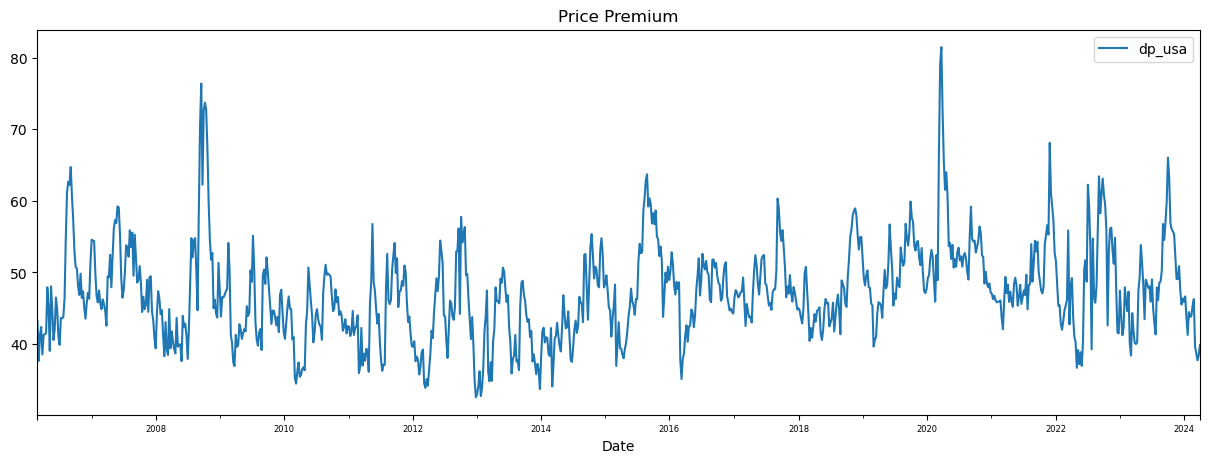

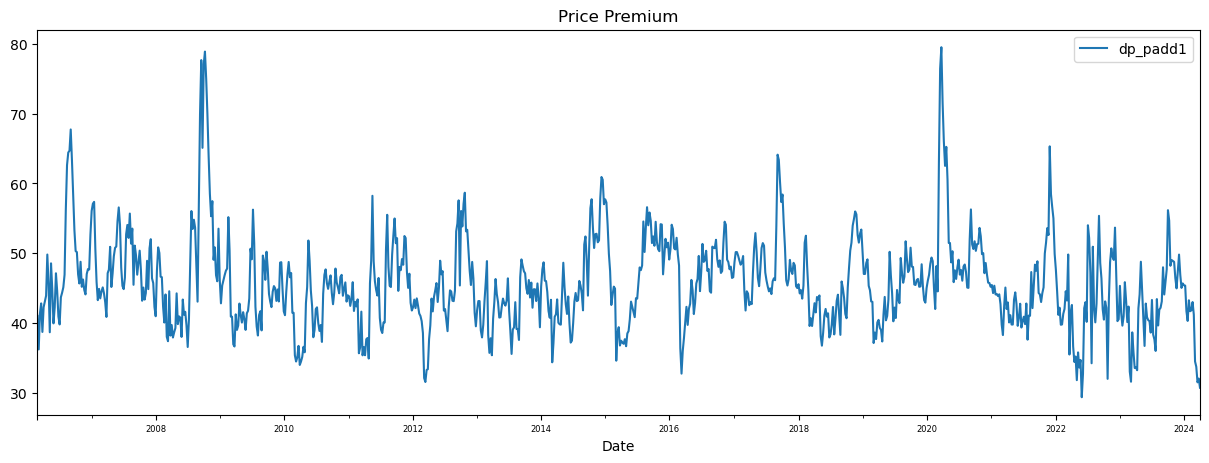

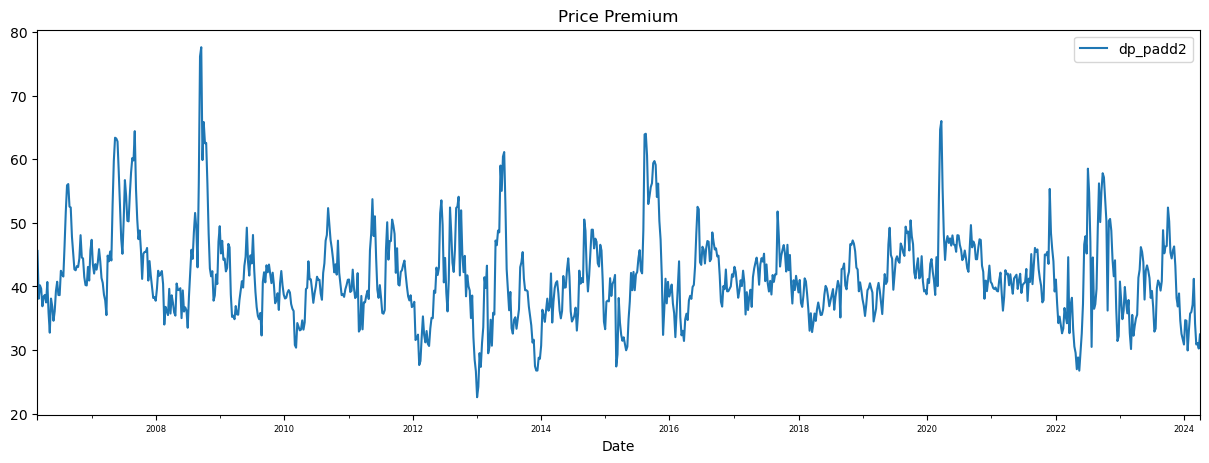

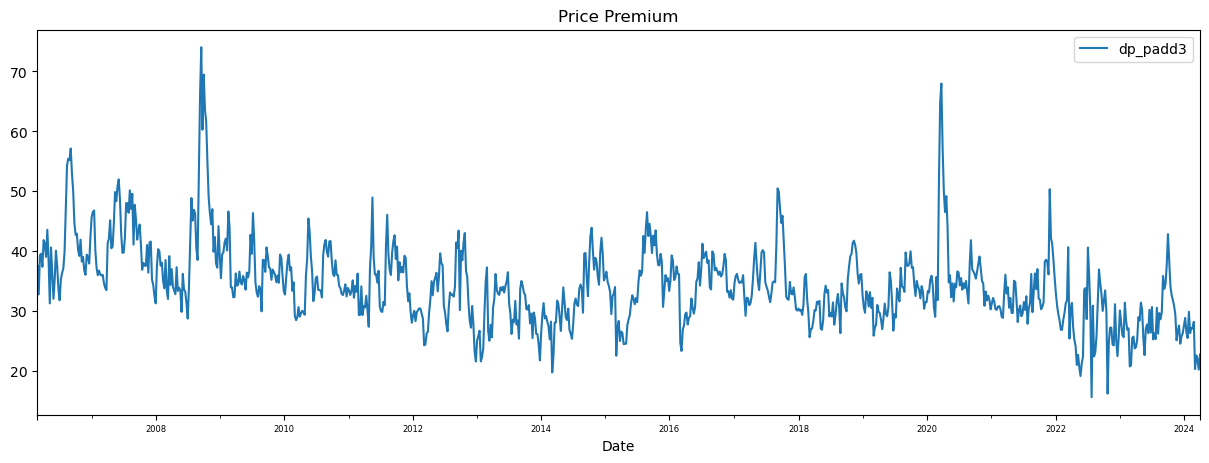

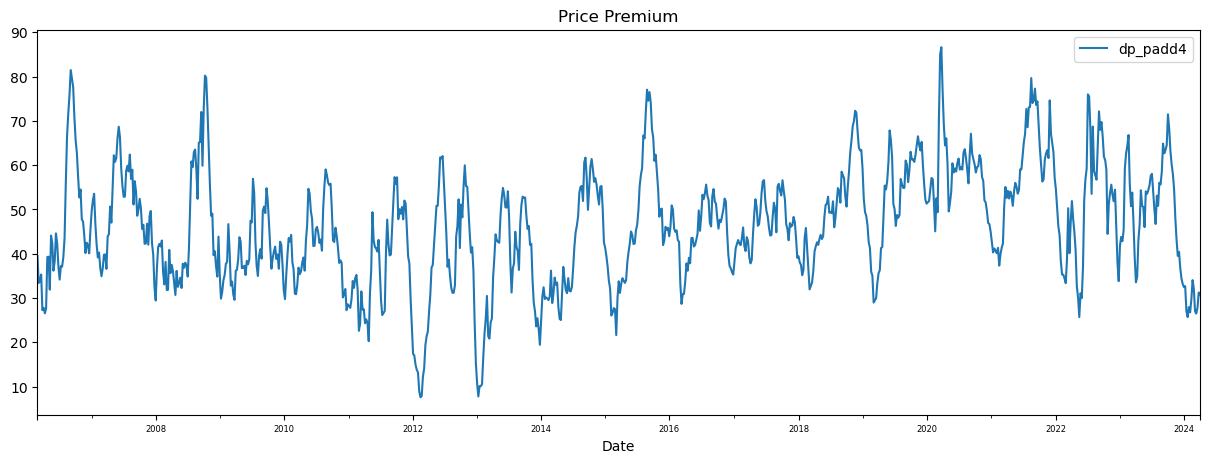

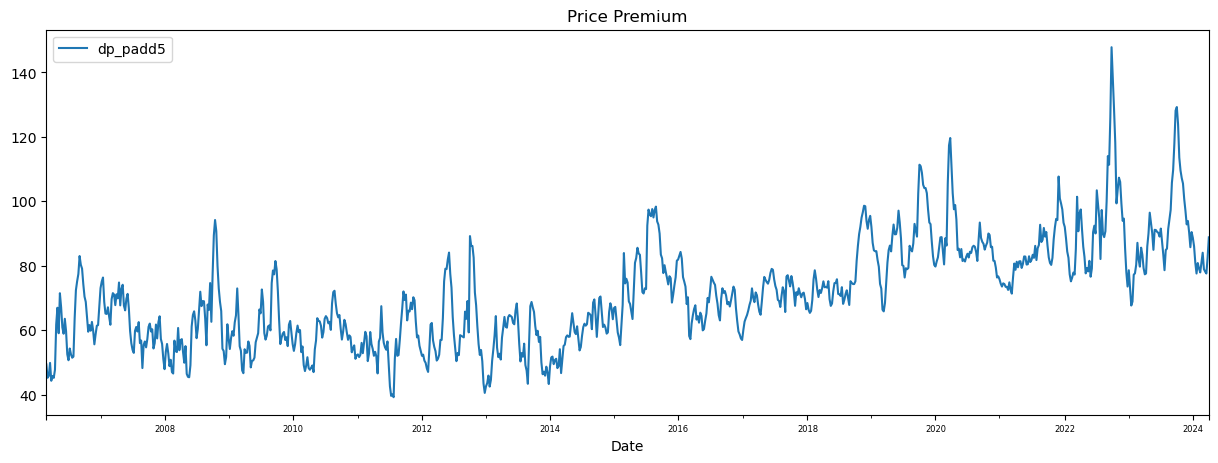

In [36]:
areas = ['usa', 'padd1', 'padd2', 'padd3', 'padd4', 'padd5',]

for area in areas:
    y = df[['dp_' + area]].dropna()
    y.plot(figsize=(15,5))
    plt.xticks(fontsize=6);    
    plt.title('Price Premium');

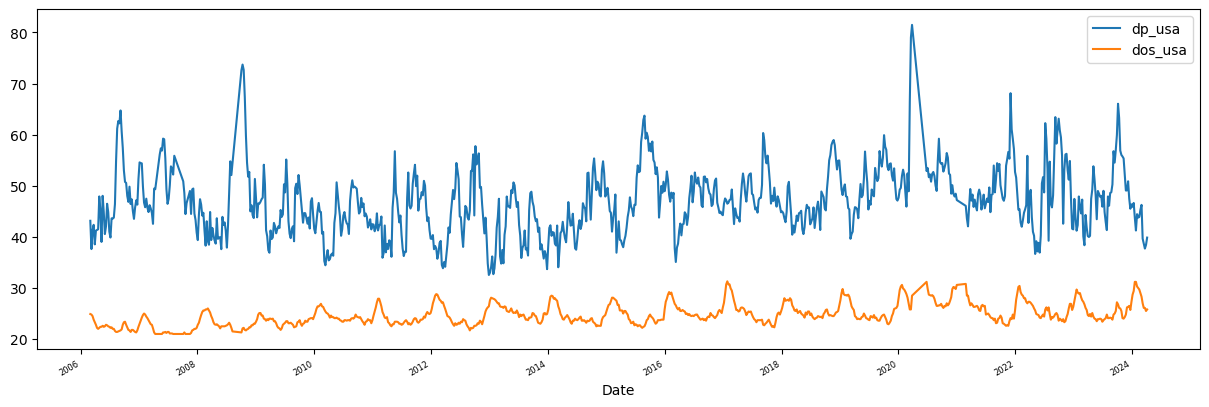

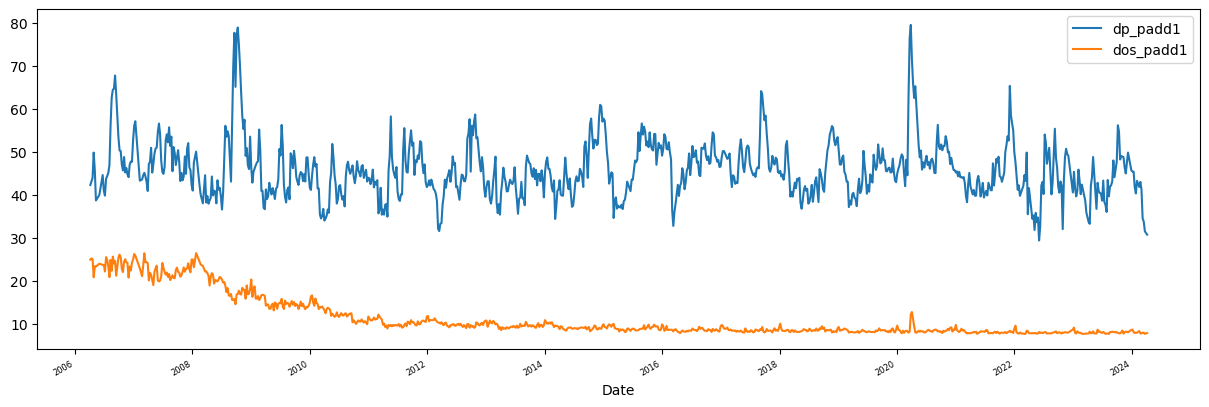

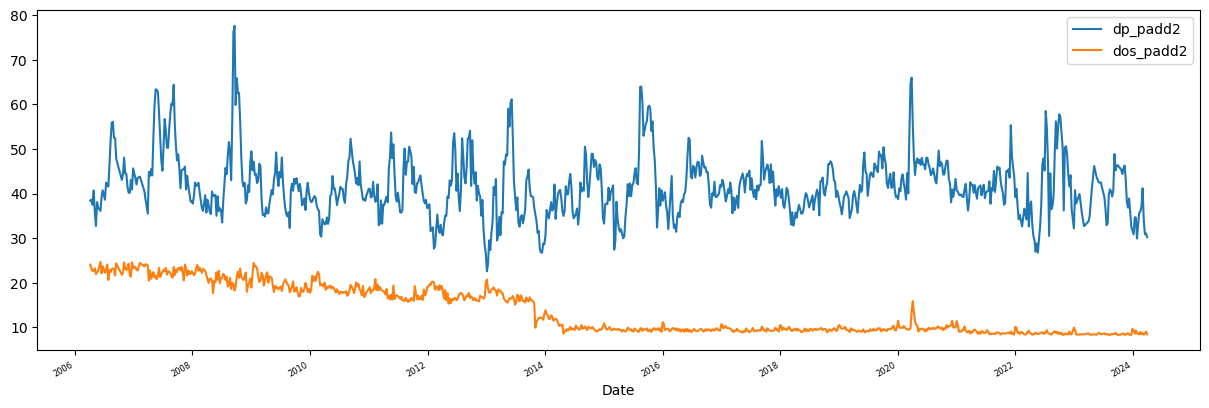

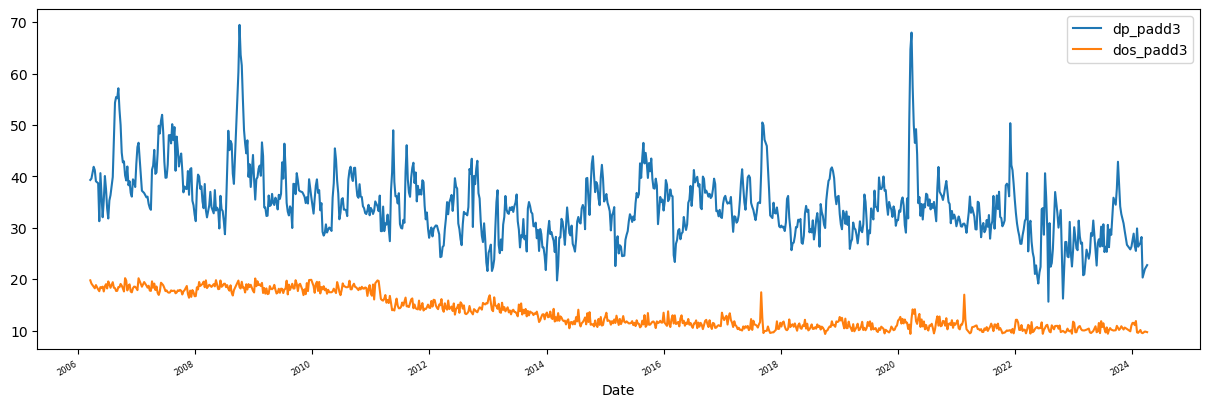

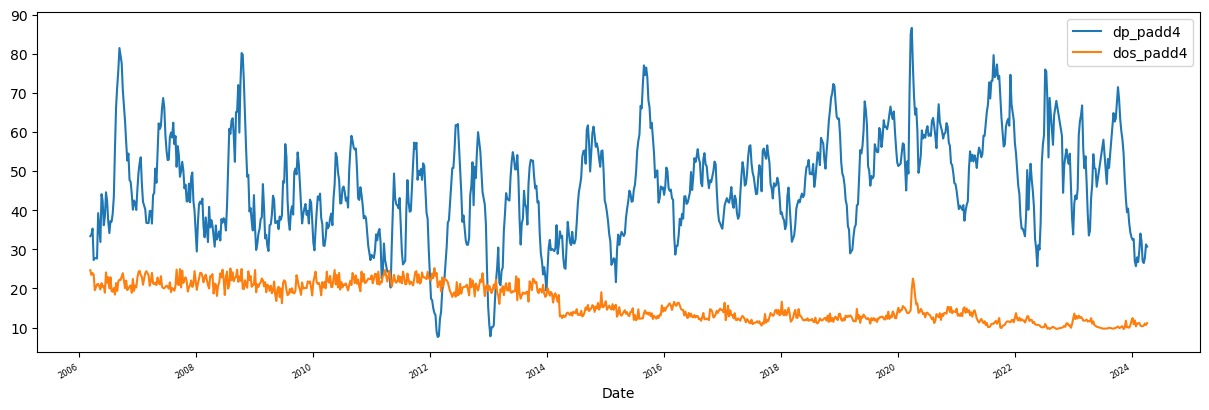

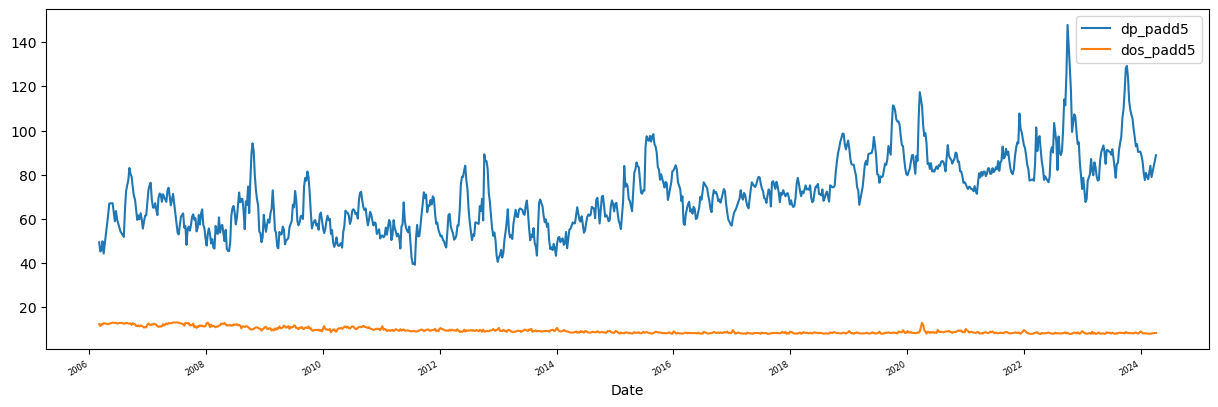

In [693]:
areas = ['usa', 'padd1', 'padd2', 'padd3', 'padd4', 'padd5',]  

low = .02
high = .98

for area in areas:
    y = df[['dp_' + area, 'dos_' + area]].dropna()
    quant_y = y[['dos_' + area]].quantile([low, high])
    y = y[ np.logical_and( y['dos_' + area] < quant_y.loc[high].values[0] , y['dos_' + area] > quant_y.loc[low].values[0] ) ]

    y.plot(figsize=(15,5))
    plt.xticks(fontsize=6);

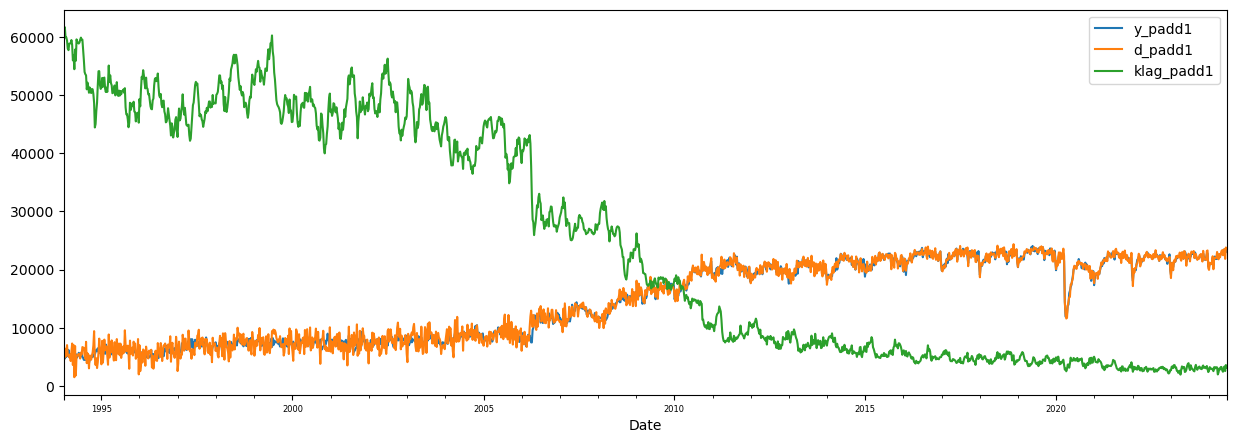

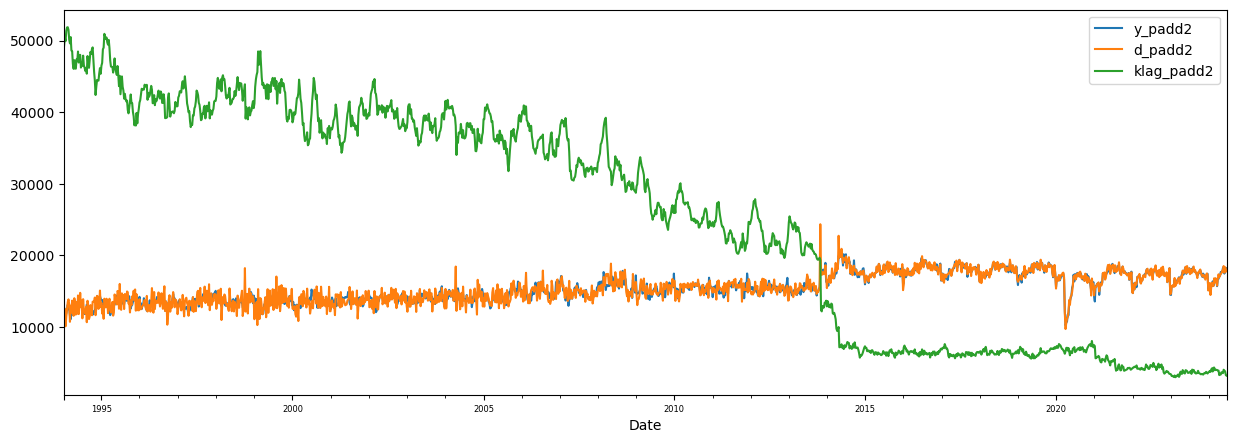

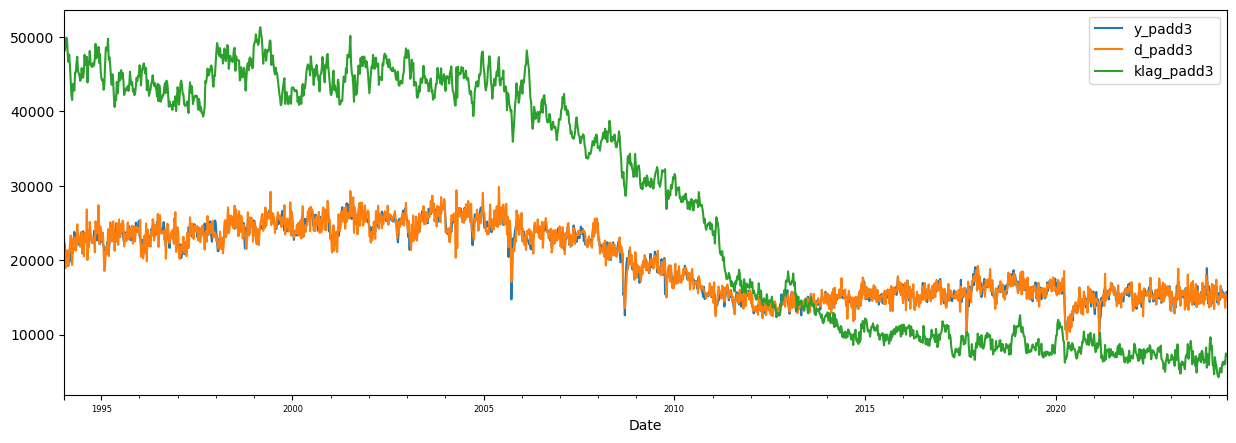

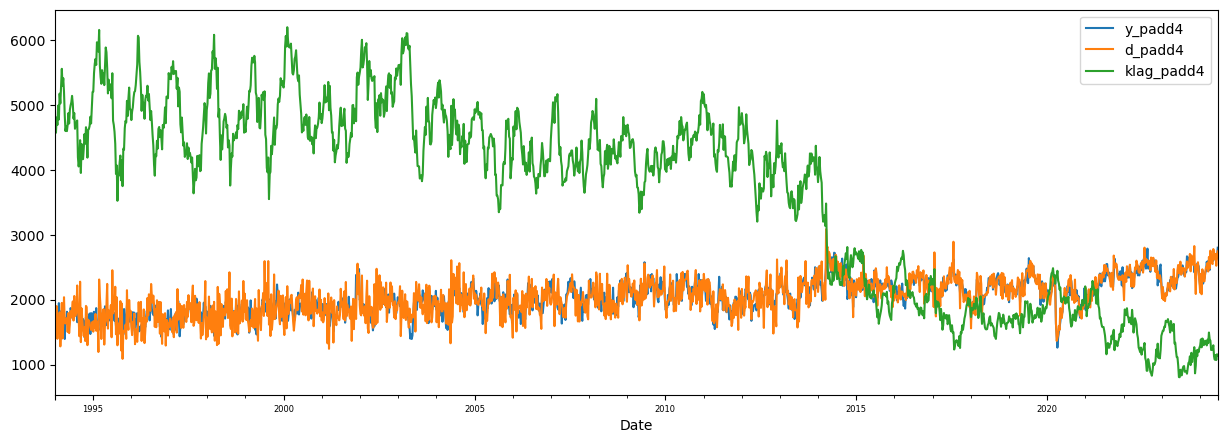

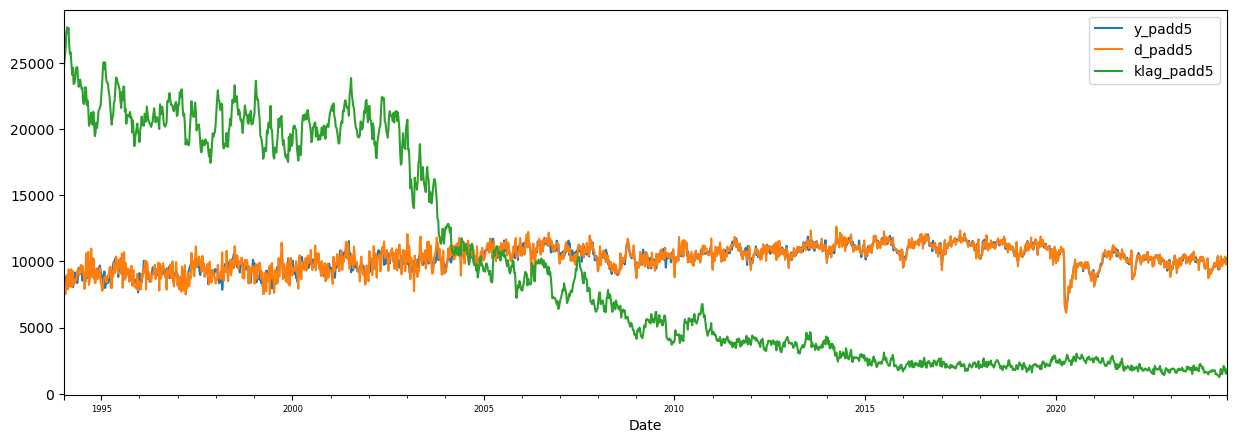

In [694]:
for area in areas[1:]:
    y = df[['y_' + area, 'd_' + area, 'klag_' + area]].dropna()
    y.plot(figsize=(15,5))
    plt.xticks(fontsize=6);  

In [695]:
# df = df[df['year']>=2016]

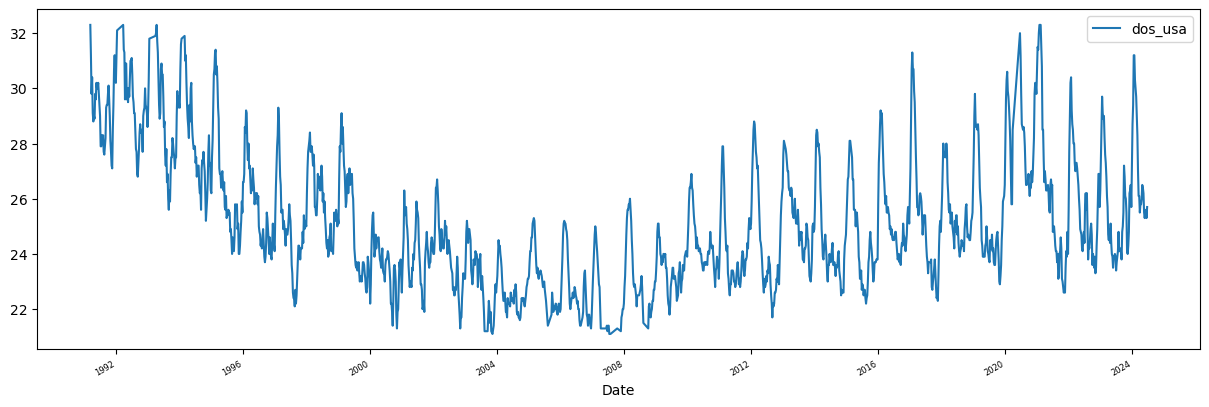

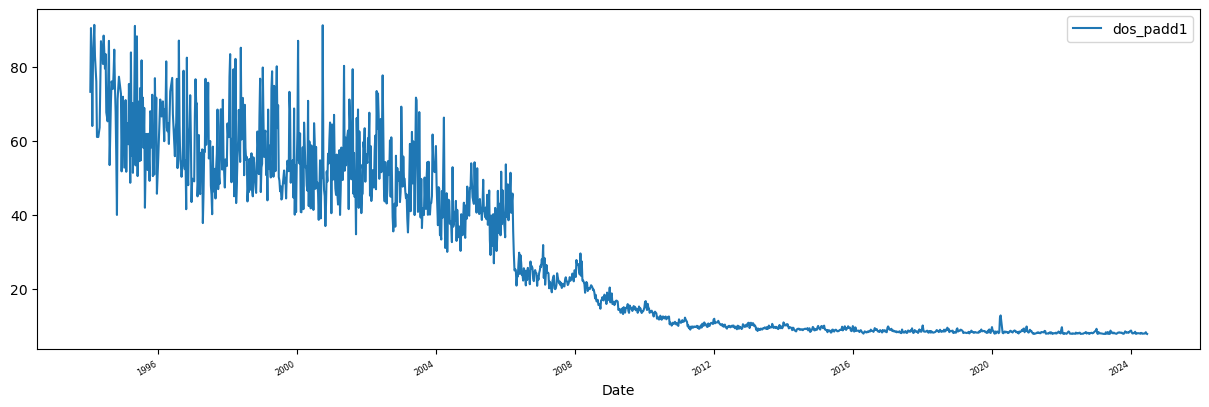

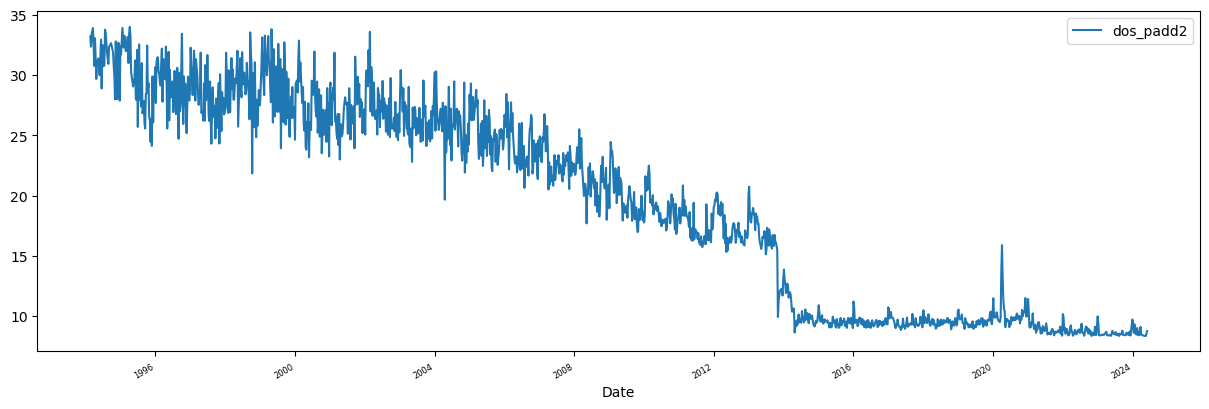

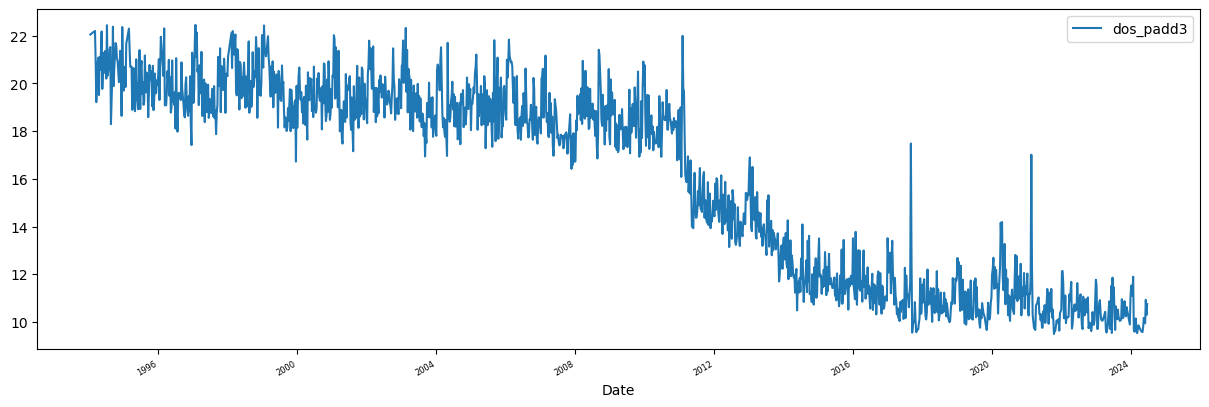

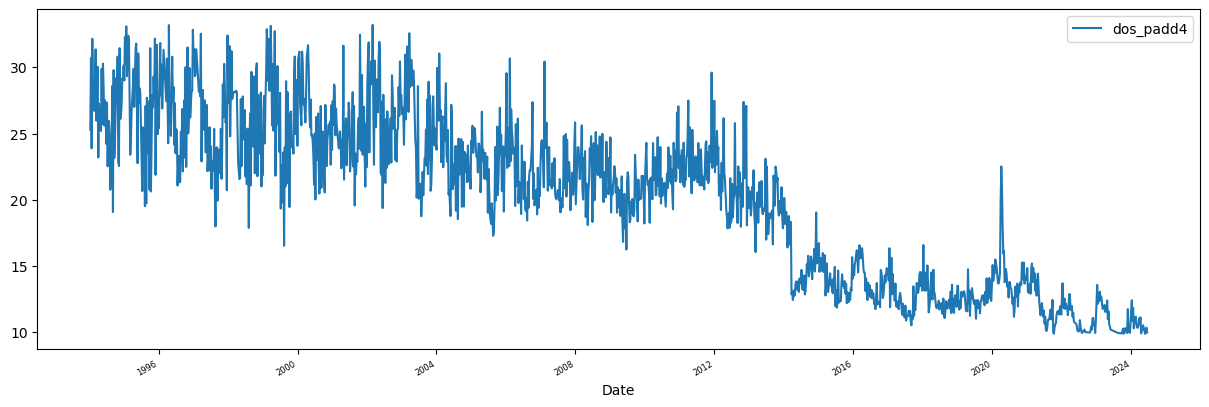

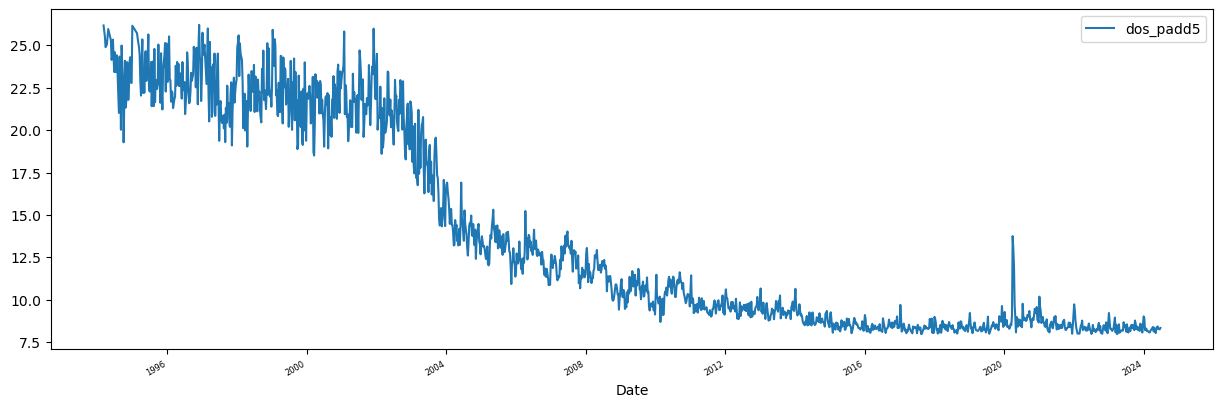

In [696]:
low = .02
high = .98

for area in areas:
    y = df[['dos_' + area]].dropna()
    quant_y = y[['dos_' + area]].quantile([low, high])

    y = y[ np.logical_and( y['dos_' + area] < quant_y.loc[high].values[0] , y['dos_' + area] > quant_y.loc[low].values[0] ) ]

    y.plot(figsize=(15,5))
    plt.xticks(fontsize=6);


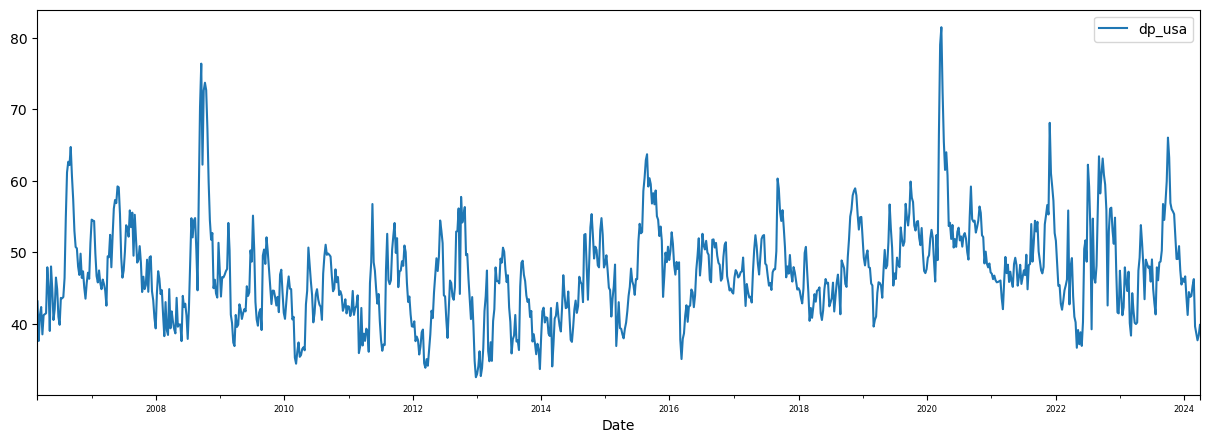

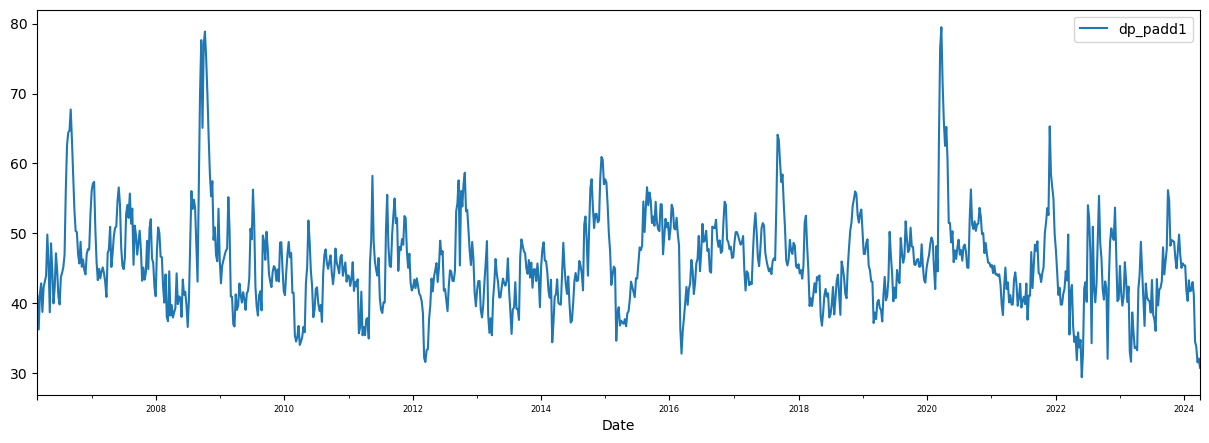

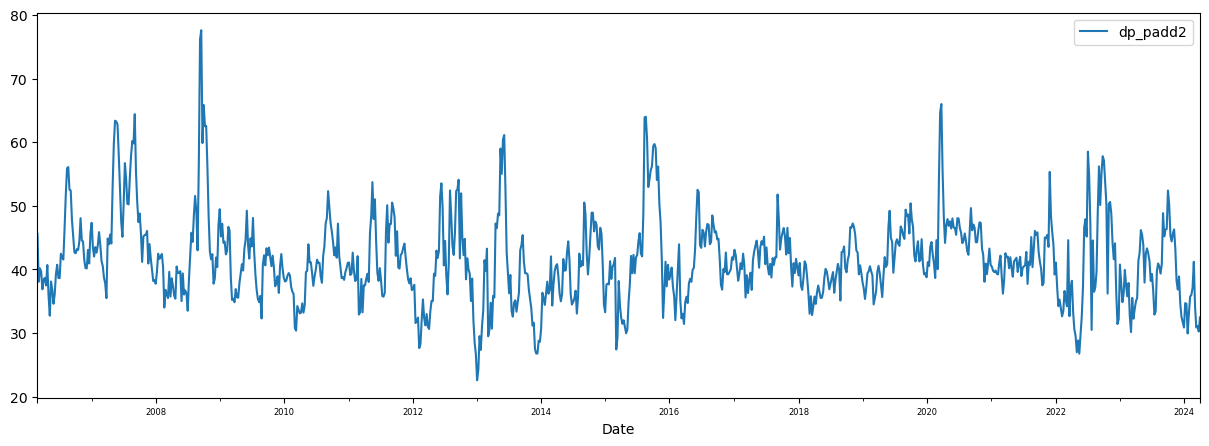

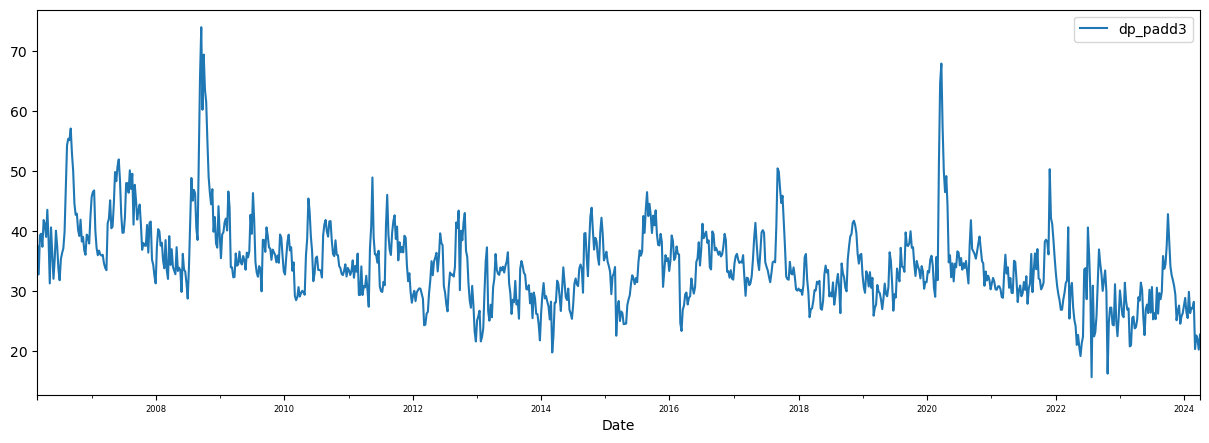

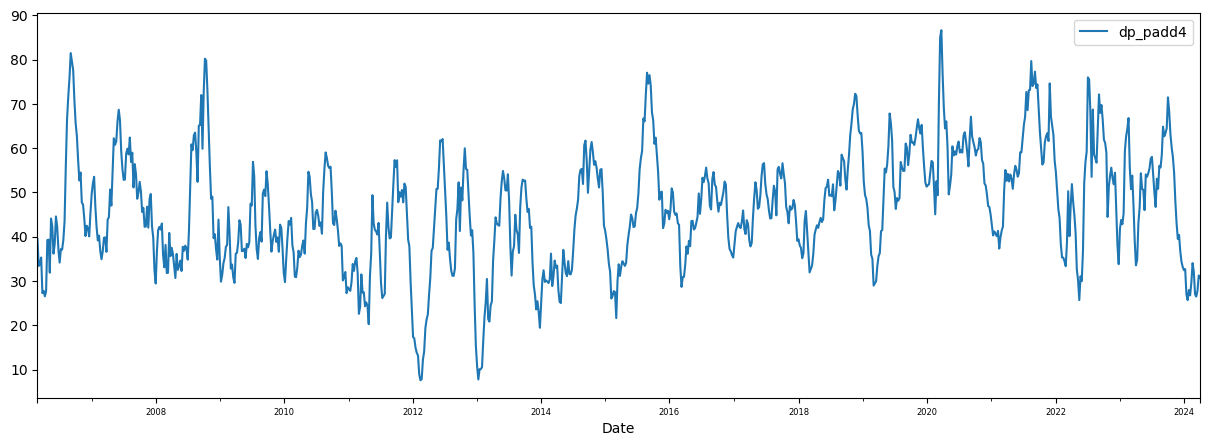

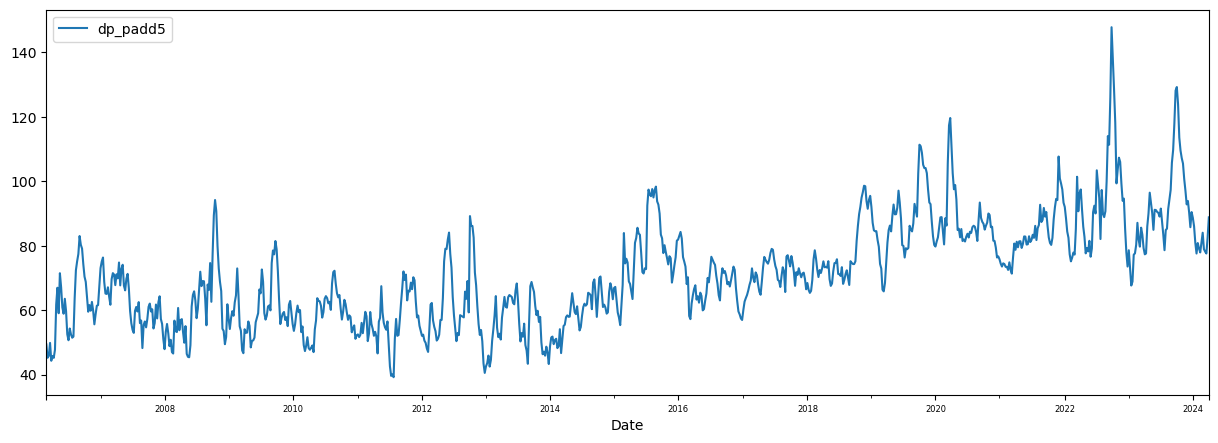

In [697]:
low = .02
high = .98

for area in areas:
    y = df[['dp_' + area]].dropna()
    
    # quant_y = y[['dp_' + area]].quantile([low, high])
    # y = y[ np.logical_and( y['dp_' + area] < quant_y.loc[high].values[0] , y['dp_' + area] > quant_y.loc[low].values[0] ) ]

    y.plot(figsize=(15,5))
    plt.xticks(fontsize=6);

In [627]:
# df = df[df['year']>=2015]

In [698]:
df[['dos_usa', 'dp_usa']].corr()

dos_usa    dp_usa
dos_usa  1.000000 -0.027314
dp_usa  -0.027314  1.000000

In [699]:
df[['dos_padd1', 'dp_padd1']].corr()

dos_padd1  dp_padd1
dos_padd1   1.000000  0.098136
dp_padd1    0.098136  1.000000

In [700]:
df[['dos_padd2', 'dp_padd2']].corr()

dos_padd2  dp_padd2
dos_padd2   1.000000  0.080747
dp_padd2    0.080747  1.000000

In [701]:
df[['dos_padd3', 'dp_padd3']].corr()

dos_padd3  dp_padd3
dos_padd3   1.000000  0.409903
dp_padd3    0.409903  1.000000

In [702]:
df[['dos_padd4', 'dp_padd4']].corr()

dos_padd4  dp_padd4
dos_padd4   1.000000 -0.314826
dp_padd4   -0.314826  1.000000

In [703]:
df[['dos_padd5', 'dp_padd5']].corr()

dos_padd5  dp_padd5
dos_padd5   1.000000 -0.450785
dp_padd5   -0.450785  1.000000

# Model Estimation

In [656]:
df = read_data("data.csv")

In [657]:
df['Date'] = df.index
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

In [658]:
df = df[df['year']>=2015]

In [659]:
df_dummy_m = pd.get_dummies(df['month'], dtype='int')
month_cols = list(map(str, list(df_dummy_m.columns)))
df_dummy_m.columns = month_cols

In [660]:
df_dummy_y = pd.get_dummies(df['year'], dtype='int')
year_cols = list(map(str, list(df_dummy_y.columns)))
df_dummy_y.columns = year_cols

In [661]:
df = pd.concat([df, df_dummy_m], axis='columns')
df = pd.concat([df, df_dummy_y], axis='columns')

In [664]:
def get_reggresion(area, df):
    df['dos'] = df['dos_' + area]
    df['dos2'] = df['dos'] * df['dos']
    df['dos3'] = df['dos2'] * df['dos']

    df['dp'] = df['dp_' + area]
    
    df = df.dropna(subset=['dp', 'dos'])

    quant = df[['dos']].quantile([low, high])

    df = df[ np.logical_and( df['dos'] < quant.loc[high].values[0] , df['dos'] > quant.loc[low].values[0] ) ]

    cols = ['dos', 'dos2', 'dos3'] + month_cols + year_cols

    X = df[cols]
    y = df['dp']

    reg = LinearRegression().fit(X, y)
    reg.coef_
    reg.intercept_
    reg.score(X, y)
    
    coeff = {}
    coeff['dos'] = reg.coef_[0]
    coeff['dos2'] = reg.coef_[1]
    coeff['dos3'] = reg.coef_[2]
    coeff['constant'] = reg.intercept_
    coeff
    
    X_ = pd.DataFrame()
    X_['dos'] = np.arange(5, 50, 0.1) 
    X_['dos2'] = X_['dos'] * X_['dos'] 
    X_['dos3'] = X_['dos2'] * X_['dos'] #.reshape(-1, 1)
    
    X_['y'] = X_['dos'] * coeff['dos'] + X_['dos2'] * coeff['dos2'] + X_['dos3'] * coeff['dos3'] + coeff['constant']
    
    y_ = X_['y'].copy()
    
    X_ = X_[['dos', 'dos2', 'dos3']]
    
    # plot
    fig, ax = plt.subplots()
    ax.plot(X_['dos'], y_, linewidth=2)
    plt.show();

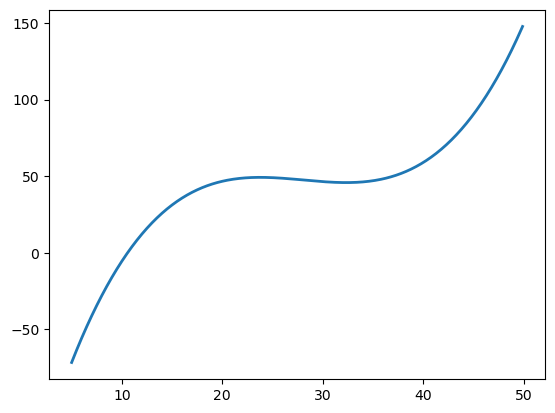

In [665]:
area = "usa"
get_reggresion(area, df)

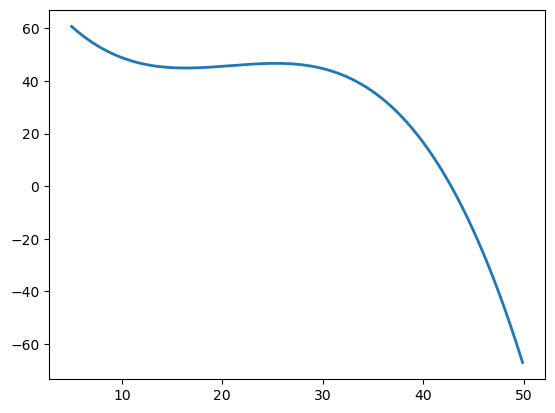

In [666]:
area = "padd1"
get_reggresion(area, df)

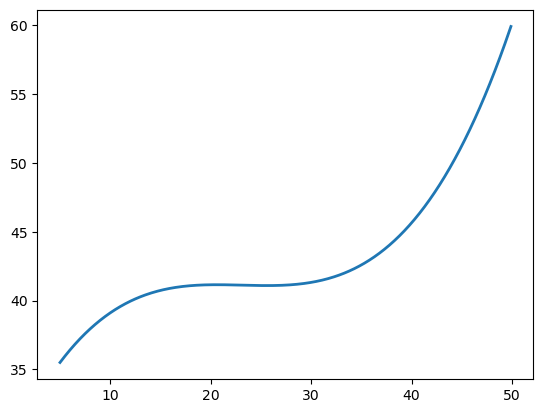

In [667]:
area = "padd2"
get_reggresion(area, df)

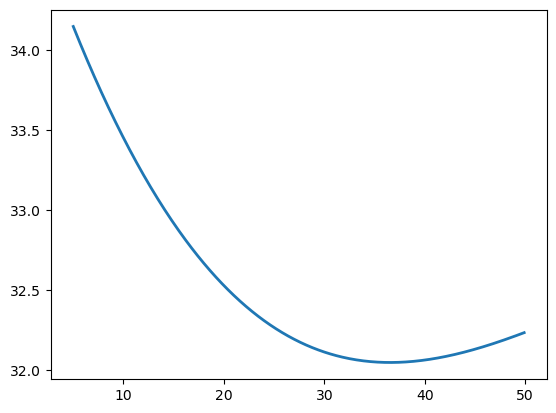

In [668]:
area = "padd3"
get_reggresion(area, df)

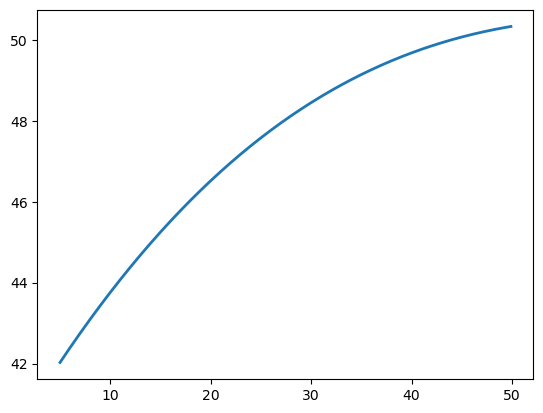

In [669]:
area = "padd4"
get_reggresion(area, df)

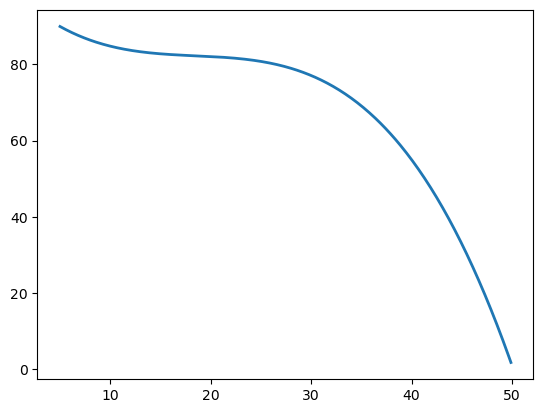

In [670]:
area = "padd5"
get_reggresion(area, df)

In [ ]:
df['dos2'] = df['dos'] * df['dos']
df['dos3'] = df['dos2'] * df['dos']
df = df.dropna(subset=['dp', 'dos'])

In [335]:
month_cols

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [336]:
cols = ['dos', 'dos2', 'dos3'] + month_cols + year_cols

In [338]:
X = df[cols]
y = df['dp']

In [ ]:
reg = LinearRegression().fit(X, y)
reg.coef_
reg.intercept_
reg.score(X, y)

coeff = {}
coeff['dos'] = reg.coef_[0]
coeff['dos2'] = reg.coef_[1]
coeff['dos3'] = reg.coef_[2]
coeff['constant'] = reg.intercept_
coeff

X_ = pd.DataFrame()
X_['dos'] = np.arange(20, 26, 0.1) 
X_['dos2'] = X_['dos'] * X_['dos'] 
X_['dos3'] = X_['dos2'] * X_['dos'] #.reshape(-1, 1)

X_['y'] = X_['dos'] * coeff['dos'] + X_['dos2'] * coeff['dos2'] + X_['dos3'] * coeff['dos3'] + coeff['constant']

y_ = X_['y'].copy()

X_ = X_[['dos', 'dos2', 'dos3']]

# plot
fig, ax = plt.subplots()
ax.plot(X_['dos'], y_, linewidth=2)
plt.show();